In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy
import numpy as np
import glob
from scipy.stats import mannwhitneyu
from matplotlib.pyplot import subplot_mosaic as mosaic
import matplotlib.transforms as mtransforms
import math
import matplotlib
import warnings
from IPython.display import Image, display
from matplotlib.ticker import MaxNLocator

warnings.filterwarnings("ignore")

### Quality control of sex annotations

Output of QC with modmatcher from modmatcher_QC.R can be found in the subdirectory /modmatcher. Workflow taken from https://rpubs.com/seungyeul/471026

In [2]:
# list genes (ensembl ids) that were used as sex markers in MODMatcher paper (pmid 25122495)
genes = ['ENSG00000129824', 'ENSG00000067048']
ct_sels_init = ['BRCA', 'COAD', 'GBM', 'HNSC', 'KIRC', 'KIRP', 'LUSC', 'LUAD', 'PCPG', 'READ', 'STAD']

In [3]:
def align(pheno, expr):
    keep = pheno.index.isin(expr.index)
    pheno = pheno[keep]
    pheno = pheno[pheno.index.isin(expr.index)]
    samples = pheno.index            
    expr = expr.loc[samples]
    expr = expr.loc[:, (expr.std() != 0)]
    pheno = pheno[pheno.index.isin(expr.index)]
    return pheno, expr

def get_expression_data(cohort):
    try:
        expression_data = pd.read_csv(os.path.join(os.getcwd(), 'datasets', f'TCGA-{cohort}.htseq_fpkm.tsv'), sep='\t', header=0, index_col=0)
    except:
        expression_data = pd.read_csv(os.path.join(os.getcwd(), 'datasets', 'brca_metabric.tsv'), sep='\t', header=0, index_col=0)
    expression_data.columns = expression_data.columns.str.split('.').str[0].tolist()
    return expression_data

def get_pheno_data(cohort):
    try:
        tissue_type_field, tissue_type = 'sample_type.samples', 'Primary Tumor'
        pheno_data = pd.read_csv(os.path.join(os.getcwd(), 'datasets', f'TCGA-{cohort}.GDC_phenotype.tsv'), sep='\t', header=0, index_col='submitter_id.samples')
    except:
        tissue_type_field, tissue_type = 'Sample Type', 'Primary'
        pheno_data = pd.read_csv(os.path.join(os.getcwd(), 'datasets', 'metabric_brca_pheno.tsv'), sep='\t', header=0, index_col=0)
    assert len(pheno_data.iloc[0]) == len(pheno_data.iloc[0].values)
    pheno_data['cohort'] = str(cohort)
    pheno_data =  pheno_data[pheno_data[tissue_type_field] == tissue_type]
    return pheno_data

### Computation of possible mismatches based on euclidean distance of sample-specific values for ENSG00000129824 and ENSG00000067048 from cohort-specific means for ENSG00000129824 and ENSG00000067048, for male and female cohorts

In [13]:
# only run once
"""
for cohort in ct_sels_init:
    print(cohort)
    # read single data
    expr = get_expression_data(cohort)
    pheno = get_pheno_data(cohort)
    # align pheno and expr
    pheno, expr = align(pheno, expr)
    expr = expr[genes]
    pheno = pheno[pheno['gender.demographic'].notna()]
    pheno_data = pheno[pheno['gender.demographic'] != 'not reported']
    expr = pd.merge(expr, pheno['gender.demographic'], left_index=True, right_index=True)
    expr.to_csv(os.path.join(os.getcwd(), 'modmatcher_data', f'{cohort}_merged.csv'))
"""

"\nfor cohort in ct_sels_init:\n    print(cohort)\n    # read single data\n    expr = get_expression_data(cohort)\n    pheno = get_pheno_data(cohort)\n    # align pheno and expr\n    pheno, expr = align(pheno, expr)\n    expr = expr[genes]\n    pheno = pheno[pheno['gender.demographic'].notna()]\n    pheno_data = pheno[pheno['gender.demographic'] != 'not reported']\n    expr = pd.merge(expr, pheno['gender.demographic'], left_index=True, right_index=True)\n    expr.to_csv(os.path.join(os.getcwd(), 'modmatcher_data', f'{cohort}_merged.csv'))\n"

In [37]:
sep = pd.DataFrame(columns=['cancer type', f'{genes[0]}', f'{genes[1]}'])
i = 0
for cohort in ct_sels_init:
    expr = pd.read_csv(os.path.join(os.getcwd(), 'modmatcher_data', f'{cohort}_merged.csv'), index_col='submitter_id.samples', header=0)

    mean_m = expr[expr['gender.demographic'] == 'male'][genes[0]].mean()
    mean_f = expr[expr['gender.demographic'] == 'female'][genes[0]].mean()
    expr['dist_f_0'] = expr.apply(lambda x: abs(np.array(x[genes[0]]) - mean_f), axis=1)
    expr['dist_m_0'] = expr.apply(lambda x: abs(np.array(x[genes[0]]) - mean_m), axis=1)
    expr['mismatch_0'] = ((expr['dist_m_0']<expr['dist_f_0']) & (expr['gender.demographic'] == 'female')) | ((expr['dist_f_0']<expr['dist_m_0']) & (expr['gender.demographic'] == 'male'))
        
    mean_m = expr[expr['gender.demographic'] == 'male'][genes[1]].mean()
    mean_f = expr[expr['gender.demographic'] == 'female'][genes[1]].mean()
    expr['dist_f_1'] = expr.apply(lambda x: abs(np.array(x[genes[1]]) - mean_f), axis=1)
    expr['dist_m_1'] = expr.apply(lambda x: abs(np.array(x[genes[1]]) - mean_m), axis=1)
    expr['mismatch_1'] = ((expr['dist_m_1']<expr['dist_f_1']) & (expr['gender.demographic'] == 'female')) | ((expr['dist_f_1']<expr['dist_m_1']) & (expr['gender.demographic'] == 'male'))
    
    sep = sep.append({'cancer type': cohort, genes[0]: len(expr[expr['mismatch_0']])/len(expr), genes[1]: len(expr[expr['mismatch_1']])/len(expr)}, ignore_index=True)
    

In [38]:
sep.style.format({
    genes[0]: '{:,.2%}'.format,
    genes[1]: '{:,.2%}'.format
})

,cancer type,ENSG00000129824,ENSG00000067048
0,BRCA,0.00%,0.00%
1,COAD,7.92%,7.28%
2,GBM,0.00%,0.00%
3,HNSC,6.00%,15.40%
4,KIRC,2.06%,4.68%
5,KIRP,9.38%,25.00%
6,LUSC,4.59%,14.77%
7,LUAD,1.34%,3.05%
8,PCPG,0.56%,1.12%
9,READ,6.06%,8.48%


<Figure size 432x288 with 0 Axes>

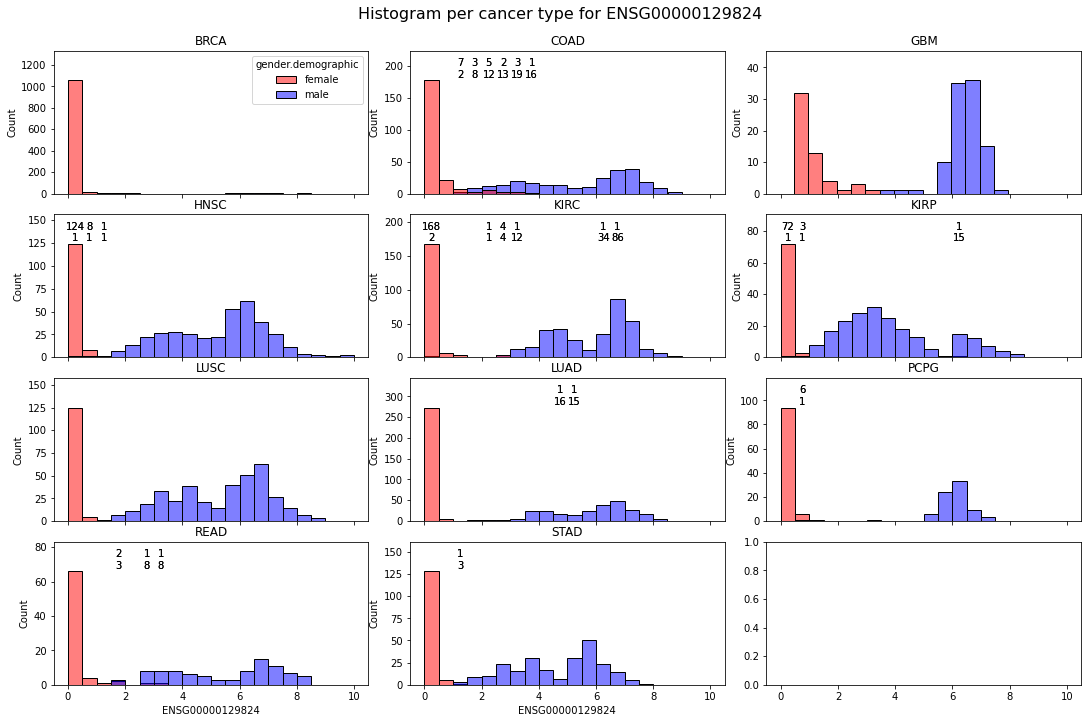

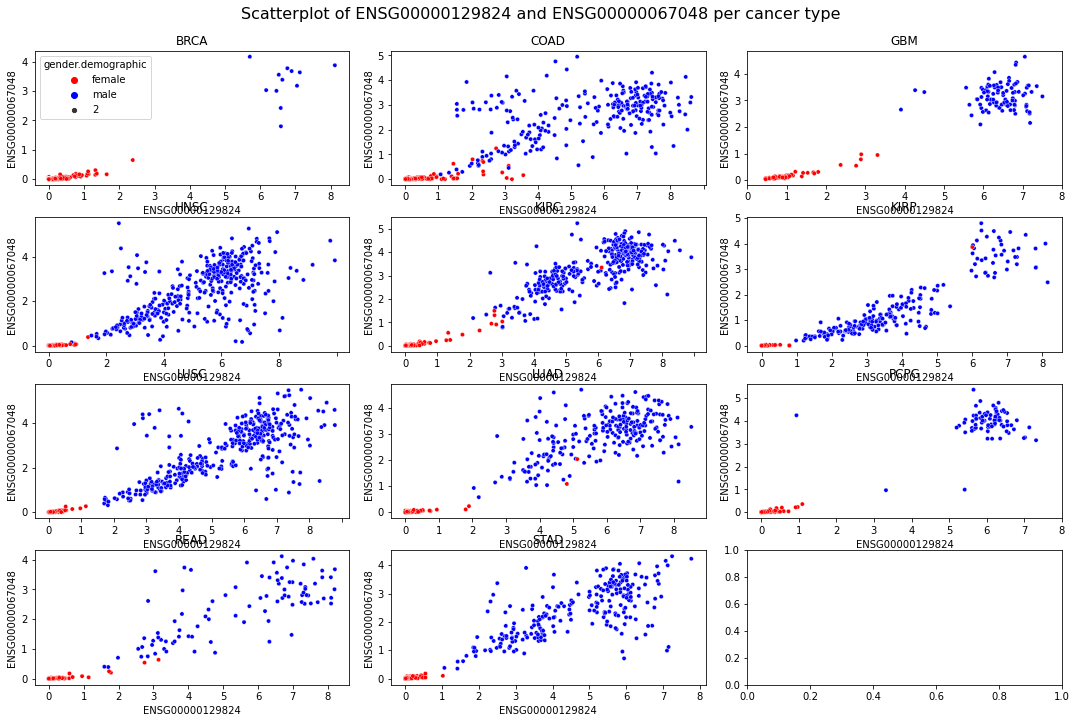

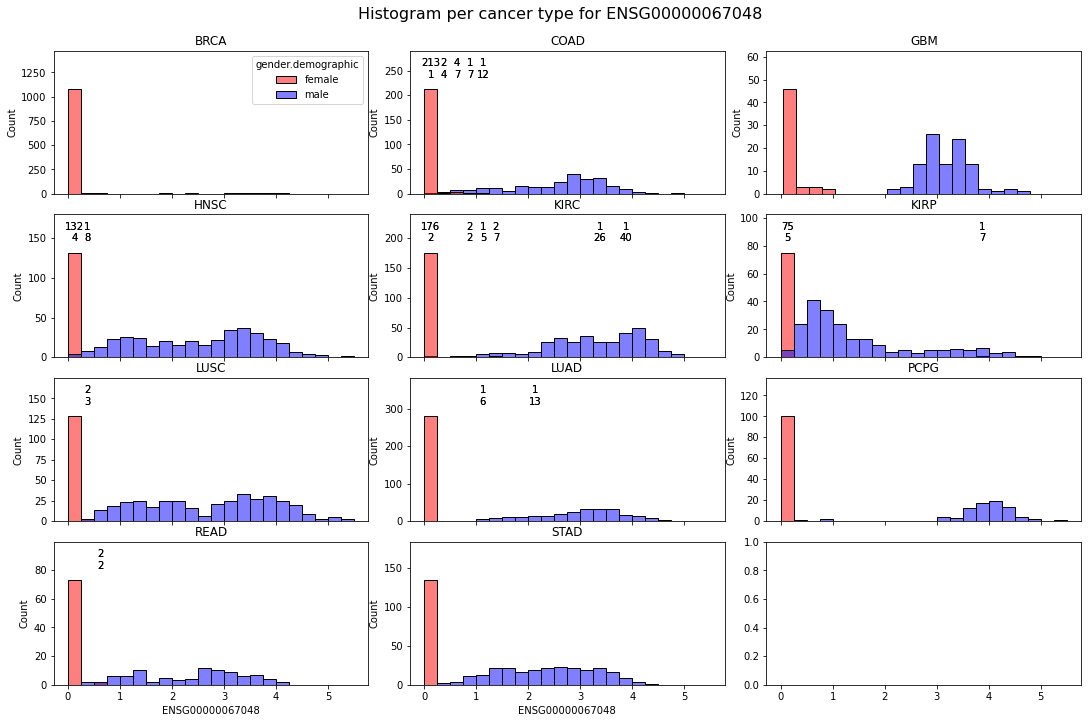

In [105]:
plt.subplots_adjust(hspace=5)

fig, axs = plt.subplots(4, 3, figsize=(15,10), sharex=True, sharey=False)
fig.suptitle(f'Histogram per cancer type for {genes[0]}\n', fontsize=16)
fig.tight_layout()
fig2, axs2 = plt.subplots(4, 3, figsize=(15,10), sharex=False, sharey=False)
fig2.suptitle(f'Scatterplot of ENSG00000129824 and ENSG00000067048 per cancer type\n', fontsize=16)
fig2.tight_layout()
fig3, axs3 = plt.subplots(4, 3, figsize=(15,10), sharex=True, sharey=False)
fig3.suptitle(f'Histogram per cancer type for {genes[1]}\n', fontsize=16)
fig3.tight_layout()

i = j = 0
for cohort in ct_sels_init:
    expr = pd.read_csv(os.path.join(os.getcwd(), 'modmatcher_data', f'{cohort}_merged.csv'), index_col='submitter_id.samples', header=0)
         
    f = expr[expr['gender.demographic'] == 'female']
    m = expr[expr['gender.demographic'] == 'male']
    
    ### Histplot ENSG00000129824
    palette = {'female': 'red', 'male': 'blue'}
    sns.histplot(expr, hue='gender.demographic', x=genes[0], ax=axs[j,i], kde=False, legend=(i==j==0), 
                 binwidth=0.5, palette=palette)
    
    axs[j,i].title.set_text(cohort)
    axs[j,i].set_ylim((0, axs[j,i].get_ylim()[1]+0.2*axs[j,i].get_ylim()[1]))
    for p in axs[j,i].patches:
        (fro, to) = p.get_bbox().x0, p.get_bbox().x1
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ct_f = len(f[(f[genes[0]] >= fro) & (f[genes[0]] < to)])
        ct_m = len(m[(m[genes[0]] >= fro) & (m[genes[0]] < to)])
        if ct_m != 0 and ct_f != 0:
            axs[j,i].annotate(f'{int(ct_f)}\n{int(ct_m)}', (x.mean(), axs[j,i].get_ylim()[1]-0.05*axs[j,i].get_ylim()[1]), ha='center', va='top')
            
    ### Scatterplot
    sns.scatterplot(expr, x=genes[0], y=genes[1], ax=axs2[j,i], hue='gender.demographic', palette=palette, size=2, legend=(i==j==0))
    axs2[j,i].set_title(f'\n{cohort}')
    
    axs2[j,i].set_xticks(range(9))
    axs2[j,i].set_xticklabels(range(9))

    axs2[j,i].xaxis.set_major_locator(MaxNLocator(integer=True))

    ### Histplot ENSG00000067048
    sns.histplot(expr, x=genes[1], ax=axs3[j,i], hue='gender.demographic', kde=False, legend=(i==j==0), 
                 binwidth=0.25, palette=palette)
    axs3[j,i].title.set_text(cohort)
    axs3[j,i].set_ylim((0, axs3[j,i].get_ylim()[1]+0.3*axs3[j,i].get_ylim()[1]))
    for p in axs3[j,i].patches:
        (fro, to) = p.get_bbox().x0, p.get_bbox().x1
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ct_f = len(f[(f[genes[1]] >= fro) & (f[genes[1]] < to)])
        ct_m = len(m[(m[genes[1]] >= fro) & (m[genes[1]] < to)])
        if ct_m != 0 and ct_f != 0:
            axs3[j,i].annotate(f'{int(ct_f)}\n{int(ct_m)}', (x.mean(), axs3[j,i].get_ylim()[1]-0.05*axs3[j,i].get_ylim()[1]), ha='center', va='top')
            
    
    i += 1
    if i == 3:
        i = 0
        j += 1
        

In [106]:
fig.savefig('histogram_RPS4Y1.pdf')
fig2.savefig('scatterplot.pdf')
fig3.savefig('histogram_DDX3Y.pdf')

In [107]:
fig.savefig('histogram_RPS4Y1.jpg')
fig2.savefig('scatterplot.jpg')
fig3.savefig('histogram_DDX3Y.jpg')